In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
# Define CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 26)  # 26 classes for A-Z

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x14x14
        x = self.pool(F.relu(self.conv2(x)))  # 64x7x7
        x = self.dropout(x)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
# EMNIST transform: rotate to fix image orientation + normalize
transform = transforms.Compose([
    transforms.RandomRotation(degrees=(90, 90)),  # rotate 90 degrees clockwise
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


In [ ]:
# Load datasets
train_dataset = datasets.EMNIST(root='./data', split='letters', train=True, download=True, transform=transform)
test_dataset = datasets.EMNIST(root='./data', split='letters', train=False, download=True, transform=transform)

# Shift labels from 1–26 to 0–25
train_dataset.targets -= 1
test_dataset.targets -= 1

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 562M/562M [00:05<00:00, 94.8MB/s]


In [ ]:
# Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Epoch [1/12] - Loss: 771.0941 - Train Acc: 87.30% - Test Acc: 91.92%
Epoch [2/12] - Loss: 418.5348 - Train Acc: 92.74% - Test Acc: 93.20%
Epoch [3/12] - Loss: 346.2732 - Train Acc: 93.75% - Test Acc: 93.72%
Epoch [4/12] - Loss: 298.4847 - Train Acc: 94.52% - Test Acc: 93.49%
Epoch [5/12] - Loss: 267.0712 - Train Acc: 94.98% - Test Acc: 94.03%
Epoch [6/12] - Loss: 241.3843 - Train Acc: 95.39% - Test Acc: 93.77%
Epoch [7/12] - Loss: 218.1548 - Train Acc: 95.69% - Test Acc: 93.88%
Epoch [8/12] - Loss: 202.1065 - Train Acc: 95.96% - Test Acc: 94.05%
Epoch [9/12] - Loss: 190.4939 - Train Acc: 96.17% - Test Acc: 94.05%
Epoch [10/12] - Loss: 177.7228 - Train Acc: 96.34% - Test Acc: 94.07%
Epoch [11/12] - Loss: 166.3003 - Train Acc: 96.54% - Test Acc: 94.10%
Epoch [12/12] - Loss: 159.2576 - Train Acc: 96.61% - Test Acc: 93.86%


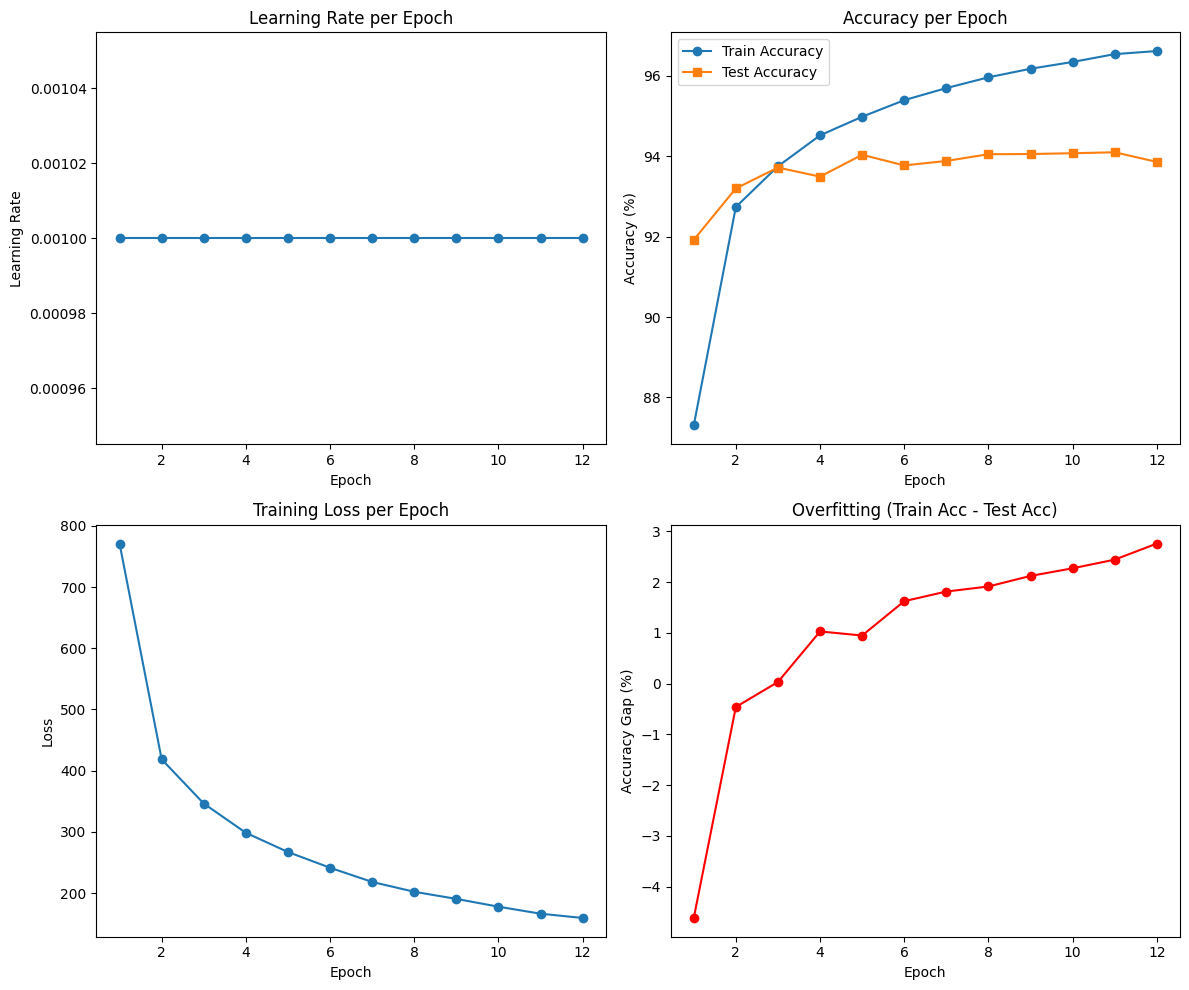

In [ ]:
import matplotlib.pyplot as plt

# Track metrics
train_accuracies = []
test_accuracies = []
losses = []
learning_rates = []
overfitting = []

# Training loop
epochs = 12
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0

    # Get current learning rate
    for param_group in optimizer.param_groups:
        current_lr = param_group['lr']
    learning_rates.append(current_lr)

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

    # Training accuracy
    train_accuracy = correct / len(train_loader.dataset) * 100
    train_accuracies.append(train_accuracy)
    losses.append(total_loss)

    # Evaluation on test set
    model.eval()
    correct_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
    test_accuracy = correct_test / len(test_loader.dataset) * 100
    test_accuracies.append(test_accuracy)

    # Overfitting measure
    overfitting.append(train_accuracy - test_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {total_loss:.4f} - Train Acc: {train_accuracy:.2f}% - Test Acc: {test_accuracy:.2f}%")

# Plotting all metrics
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 10))

# Plot Learning Rate
plt.subplot(2, 2, 1)
plt.plot(epochs_range, learning_rates, marker='o')
plt.title("Learning Rate per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")

# Plot Training & Testing Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy', marker='s')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

# Plot Training Loss
plt.subplot(2, 2, 3)
plt.plot(epochs_range, losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Plot Overfitting Measure
plt.subplot(2, 2, 4)
plt.plot(epochs_range, overfitting, marker='o', color='red')
plt.title("Overfitting (Train Acc - Test Acc)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy Gap (%)")

plt.tight_layout()
plt.show()


In [ ]:
# Testing
model.eval()
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / len(test_loader.dataset) * 100
print(f"\nTest Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 93.86%


In [ ]:
import os
import cv2
import numpy as np
import torch
import string
from PIL import Image
from torchvision import transforms
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Label mappings
label_map = {i: c for i, c in enumerate(string.ascii_uppercase)}
reverse_label_map = {v: k for k, v in label_map.items()}

# Preprocessing (EMNIST-style)
def preprocess_custom_image(path):
    image = cv2.imread(path)

    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if np.mean(image) > 90:
        image = 255 - image

    image = cv2.GaussianBlur(image, (3, 3), 0)
    shadow_variance = np.std(image)
    brightness_range = np.max(image) - np.min(image)

    if brightness_range < 100:
        _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    elif shadow_variance > 30:
        _, image = cv2.threshold(image, 180, 255, cv2.THRESH_BINARY)
    else:
        _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    coords = cv2.findNonZero(image)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        image = image[y:y+h, x:x+w]

    h, w = image.shape
    if h > w:
        new_h, new_w = 25, int((w / h) * 25)
    else:
        new_w, new_h = 25, int((h / w) * 25)
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    top = (28 - new_h) // 2
    bottom = 28 - new_h - top
    left = (28 - new_w) // 2
    right = 28 - new_w - left
    image = np.pad(image, ((top, bottom), (left, right)), mode='constant', constant_values=0)

    M = cv2.moments(image)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        shiftx = int(14 - cx)
        shifty = int(14 - cy)
        M_shift = np.float32([[1, 0, shiftx], [0, 1, shifty]])
        image = cv2.warpAffine(image, M_shift, (28, 28))

    image = Image.fromarray(image)
    final_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
        transforms.Lambda(lambda x: torch.rot90(x, 2, [1, 2])),  # 180°
        transforms.Lambda(lambda x: torch.flip(x, [2]))          # Horizontal flip
    ])
    return final_transform(image)

# Inference loop
custom_image_folder = '/content/drive/MyDrive/A-Z'
model.eval()

correct = 0
total = 0

print(f"{'Filename':<20} {'True':<5} {'Pred':<5}")

for filename in sorted(os.listdir(custom_image_folder)):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')) and filename[0].upper() in reverse_label_map:
        true_char = filename[0].upper()
        true_label = reverse_label_map[true_char]

        img_path = os.path.join(custom_image_folder, filename)
        transformed = preprocess_custom_image(img_path).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(transformed)
            _, predicted = torch.max(output, 1)
            predicted_label = predicted.item()

        predicted_char = label_map[predicted_label]
        print(f"{filename:<20} {true_char:<5} {predicted_char:<5}")

        if predicted_label == true_label:
            correct += 1
        total += 1

accuracy = (correct / total) * 100 if total > 0 else 0
print(f"\nAccuracy: {accuracy:.2f}% ({correct}/{total})")


ValueError: mount failed

just testing the similarity of custom and emnist

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Label map for EMNIST letters A-Z → 0-25
label_map = {chr(i + 65): i for i in range(26)}

# Custom image preprocessing (EMNIST-style)
def preprocess_custom_image(path):
    image = cv2.imread(path)

    # Convert to grayscale if needed
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Invert if background is white
    if np.mean(image) > 90:
        image = 255 - image

    # Blur before threshold
    image = cv2.GaussianBlur(image, (3, 3), 0)
    shadow_variance = np.std(image)
    brightness_range = np.max(image) - np.min(image)

    if brightness_range < 100:
        _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    elif shadow_variance > 30:
        _, image = cv2.threshold(image, 180, 255, cv2.THRESH_BINARY)
    else:
        _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Crop using bounding box
    coords = cv2.findNonZero(image)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        image = image[y:y+h, x:x+w]

    # Resize while keeping aspect ratio
    h, w = image.shape
    if h > w:
        new_h, new_w = 25, int((w / h) * 25)
    else:
        new_w, new_h = 25, int((h / w) * 25)
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Pad to 28x28
    top = (28 - new_h) // 2
    bottom = 28 - new_h - top
    left = (28 - new_w) // 2
    right = 28 - new_w - left
    image = np.pad(image, ((top, bottom), (left, right)), mode='constant', constant_values=0)

    # Center using moments
    M = cv2.moments(image)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        shiftx = int(14 - cx)
        shifty = int(14 - cy)
        M_shift = np.float32([[1, 0, shiftx], [0, 1, shifty]])
        image = cv2.warpAffine(image, M_shift, (28, 28))

    # Final transform: rotate + normalize
    image = Image.fromarray(image)
    final_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
        transforms.Lambda(lambda x: torch.rot90(x, 2, [1, 2])),  # Correct 90° clockwise
        transforms.Lambda(lambda x: torch.flip(x, [2]))          # Flip horizontally
    ])
    return final_transform(image).squeeze(0)  # remove batch dim


# Function to compare and show images
def show_custom_vs_emnist_from_drive(filename, drive_folder, emnist_dataset):
    label_chr = filename[0].upper()
    if label_chr not in label_map:
        print(f"Invalid label character: {label_chr}")
        return
    label_idx = label_map[label_chr]

    # Load and preprocess custom image
    img_path = os.path.join(drive_folder, filename)
    custom_tensor = preprocess_custom_image(img_path)
    custom_np = custom_tensor.numpy()

    # Find EMNIST sample with same label
    for img, label in emnist_dataset:
        if label == label_idx:
            emnist_np = img.squeeze().numpy()
            break

    # Display side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(custom_np, cmap='gray')
    axs[0].set_title(f"Custom Image\n'{label_chr}'")
    axs[0].axis("off")

    axs[1].imshow(emnist_np, cmap='gray')
    axs[1].set_title(f"EMNIST Sample\n'{label_chr}'")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

# Usage
custom_drive_folder = "/content/drive/MyDrive/A-Z"
custom_filename = "C_pri.jpeg"  # Adjust to match your actual file

show_custom_vs_emnist_from_drive(custom_filename, custom_drive_folder, train_dataset)
